In [1]:
!pip install vit-pytorch linformer
!pip install -q kaggle 

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=222402ce7cb5618499f9f77dd09aa119e4b46028d0c04495f2ac2bffd546eb1a
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [3]:
!git clone https://github.com/Gilf641/torchly.git

Cloning into 'torchly'...
remote: Enumerating objects: 234, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (186/186), done.
remote: Total 234 (delta 116), reused 131 (delta 41), pack-reused 0
Receiving objects: 100% (234/234), 130.21 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (116/116), done.


In [4]:
import os
import random 
import glob
import zipfile
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

from PIL import Image 
from itertools import chain
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from __future__ import print_function 


from linformer import Linformer
from vit_pytorch.efficient import ViT


import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset


import torchly
from torchly.data.dataloader import convert
from torchly.utils import data_utils, model_utils



  pip install torch-lr-finder -v --global-option="amp"


In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)


Mounted at /content/gdrive


In [7]:
!cd /content/gdrive/MyDrive/Kaggle/

In [8]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle/"

In [9]:
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition


 98% 796M/814M [00:03<00:00, 251MB/s]
100% 814M/814M [00:03<00:00, 253MB/s]


In [10]:
zipfilepath = '/content/dogs-vs-cats-redux-kernels-edition.zip'
datasetpath = '/content/gdrive/MyDrive/Kaggle/CatsVsDogs'
import zipfile
# with zipfile.ZipFile(zipfilepath, 'r') as zip_ref:
#     zip_ref.extractall(datasetpath)

In [11]:
# HyperParams

BATCH_SIZE = 64
EPOCHS = 20
LR = 1e-5
GAMMA = 0.7

In [22]:
# Load Dataset
!cd /content/gdrive/MyDrive/Kaggle/CatsVsDogs/
!mkdir data

train_zip = 'train.zip'
test_zip = 'test.zip'

mkdir: cannot create directory ‘data’: File exists


In [ ]:
datasetpath = '/content/gdrive/MyDrive/Kaggle/CatsVsDogs'

def extract(zipfile_name):
  zipfilepath = os.path.join(datasetpath, zipfile_name)
  
  with zipfile.ZipFile(zipfilepath, 'r') as zip_ref:
      zip_ref.extractall(datasetpath)
  
# extract(train_zip)

# extract(test_zip)


In [28]:
train_dir, test_dir = os.path.join(datasetpath, 'train'), os.path.join(datasetpath, 'test')

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir,'*.jpg'))

labels = [path.split('/')[-1].split('.')[0] for path in train_list]


25000

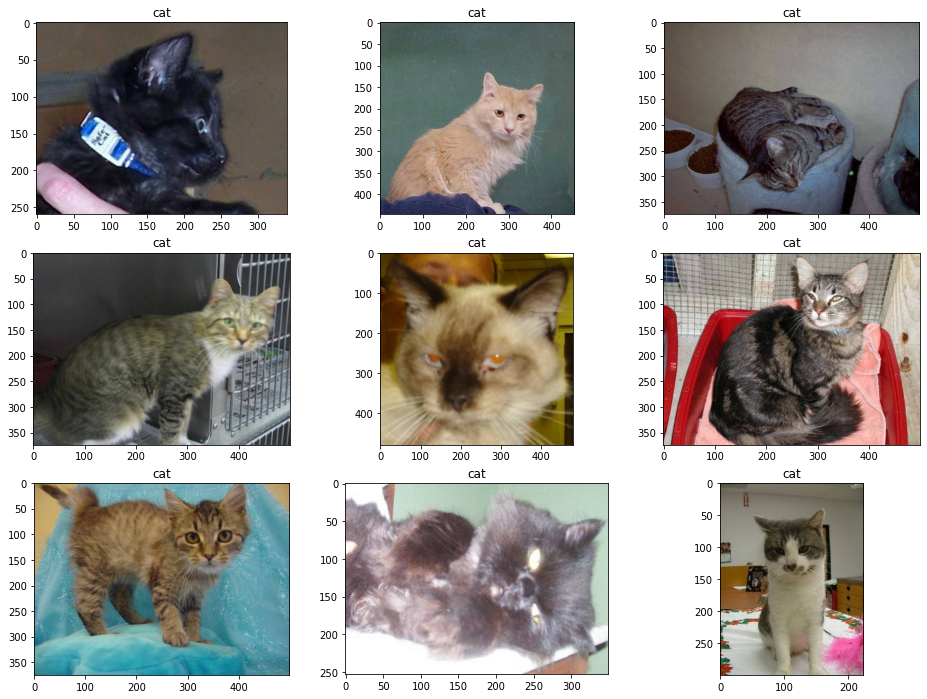

In [32]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

### Split Dataset into Train and Test 

In [33]:
train_list, valid_list = train_test_split(train_list, test_size=0.2, stratify=labels, random_state=987)

len(train_list), len(valid_list), len(test_list)

(20000, 5000, 12500)

### Transforms

In [34]:

train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
valid_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)
test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

### Cats and Dogs Dataset

In [42]:
random_image, random_label = Image.open('/content/cat.jpg'), 'cat'

In [58]:
class CatsandDogs(Dataset):
  def __init__(self, file_list, transform=None):
    self.file_list = file_list
    self.transform = transform

  def __len__(self):
    return len(self.file_list)

  def __getitem__(self,idx):
    path = self.file_list[idx]
    try:
      image = Image.open(path)
        
      transformed_image = self.transform(image)
      label = path.split("/")[-1].split(".")[0]
      label = 1 if label == "dog" else 0
      return transformed_image, label
    except Exception as e:
      print(f'Image {idx} cannot be read, due to {e}')
      transformed_image = self.transform(random_image)
      return transformed_image, 0
      

### Convert Dataset to Dataloader

In [59]:
def convert2loader(file_list, transforms, batch_size, shuffle=True):
  data = CatsandDogs(file_list, transforms)
  loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=shuffle)
  return data, loader

train_data, train_loader = convert2loader(train_list, train_transforms, BATCH_SIZE, shuffle=True)
valid_data, valid_loader = convert2loader(valid_list, valid_transforms, BATCH_SIZE, shuffle=True)
test_data, test_loader = convert2loader(test_list, test_transforms, BATCH_SIZE, shuffle=True)



### LinTransformer

In [60]:

efficient_transformer = Linformer(
    dim=768,
    seq_len=196+1,  # 14x14 patches + 1 cls-token
    depth=12,
    heads=12,
    k=64
)

### Visual Transformer

In [61]:
#Visual transformer 
model = ViT(
    dim=768,
    image_size=224,
    patch_size=16,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [62]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=GAMMA)

In [63]:
len(os.listdir('/content/gdrive/MyDrive/Kaggle/CatsVsDogs/train'))

25000

In [ ]:
for epoch in range(2):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

  0%|          | 0/313 [00:00<?, ?it/s]

Image 7637 cannot be read, due to cannot identify image file '/content/gdrive/MyDrive/Kaggle/CatsVsDogs/train/cat.4689.jpg'
